In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Arrhythmia, also known as irregular heartbeat, refers to a problem with the rate or rhythm of your heartbeat.

In [3]:
# .dat – Raw signal data hota hai (e.g. ECG), binary format mein. - waveform database wfdb decode n read krega isko. - wfdb.rdrecord(file)

# .hea – Signal ka metadata hota hai, jaise sampling rate, channel names (text format). header file.

# .atr – Annotations hote hain, jaise heartbeats, R-peaks, beat types (N, V, A, etc.). - wfdb.rdann(file)

In [4]:
# The R-peak is the highest point in ECG signal graph. - heartbeat ka time btata hai. agr 2 R peak ka time interval abnormal hai to arrhythmia ka sign hai.
# HRV is the gap / variation in time between successive R-peaks (R-R intervals).
# --- extracting them by biospy lib

In [5]:
# Beat types
# Normal (N): Normal sinus rhythm beats.
# Ventricular Ectopic (V): Abnormal beats originating from the ventricles (e.g., ventricular premature beats).
# Supraventricular Ectopic (S): Abnormal beats originating above the ventricles (e.g., atrial premature beats).
# Fusion (F): Beats that are a mix of normal and ventricular ectopic activity.

In [6]:
# wfdb: Reads ECG signals and annotations from PhysioNet datasets.

# pywt (PyWavelets): Denoises ECG using wavelet transform.

# biosppy: Automatically processes ECG to detect R-peaks and extract features.

# pyts: Converts ECG time-series into GAF images for CNN input.

# imbalanced-learn: Balances arrhythmia classes using SMOTE oversampling.

# tf-keras-vis: Visualizes CNN attention (e.g., Grad-CAM) on GAF images.

# peakutils: Detects R-peaks in ECG using thresholding and distance.

In [7]:
!pip install wfdb PyWavelets biosppy pyts imbalanced-learn tf-keras-vis peakutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 136.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wfdb
import pywt
from biosppy.signals import ecg
from pyts.image import GramianAngularField

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

import os
from pathlib import Path

from tf_keras_vis.gradcam import Gradcam
from scipy.stats import ttest_ind


import warnings
warnings.filterwarnings('ignore')

In [9]:
import os

dataset_path = '/content/drive/MyDrive/ECG - Project/mit-bih-arrhythmia-database'

all_files = os.listdir(dataset_path)
dat_files = [f for f in all_files if f.endswith('.dat')]

print(f'Total .dat ECG recordings: {len(dat_files)}')
print(f'Sample files: {dat_files[:5]}')


Total .dat ECG recordings: 48
Sample files: ['105.dat', '106.dat', '103.dat', '104.dat', '101.dat']


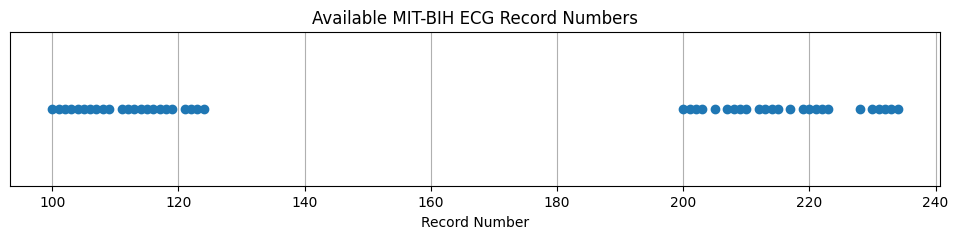

In [10]:
import re
import matplotlib.pyplot as plt

record_numbers = [int(re.findall(r'\d+', f)[0]) for f in dat_files]
plt.figure(figsize=(12, 2))
plt.plot(record_numbers, [1]*len(record_numbers), 'o', label='Record Exists')
plt.xlabel('Record Number')
plt.yticks([])
plt.title('Available MIT-BIH ECG Record Numbers')
plt.grid(True, axis='x')
plt.show()


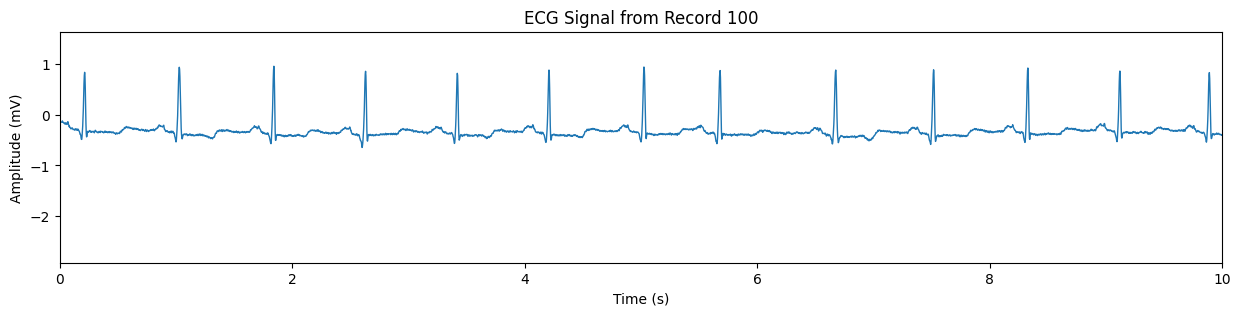

In [11]:
import wfdb

sample_record = '100'
record_path = os.path.join(dataset_path, sample_record)

record = wfdb.rdrecord(record_path)
signal = record.p_signal[:, 0]  # Channel 0 (usually MLII)
fs = record.fs

plt.figure(figsize=(15, 3))
plt.plot(np.arange(0, len(signal))/fs, signal, lw=1)
plt.title('ECG Signal from Record ' + sample_record)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.xlim(0, 10)
plt.show()


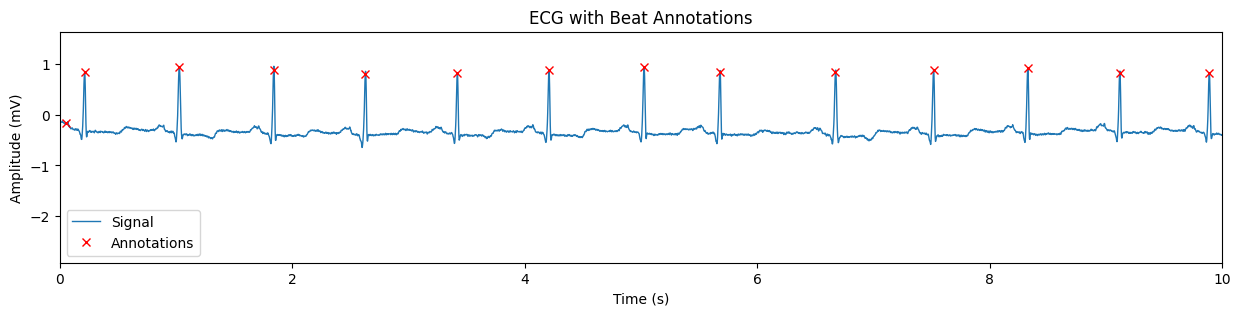

In [12]:
annot = wfdb.rdann(record_path, 'atr')
times = annot.sample / fs

plt.figure(figsize=(15, 3))
plt.plot(np.arange(0, len(signal))/fs, signal, lw=1, label='Signal')
plt.plot(times, signal[annot.sample], 'rx', label='Annotations')
plt.title('ECG with Beat Annotations')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.xlim(0, 10)
plt.show()


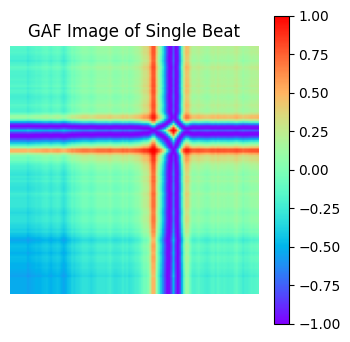

In [13]:
# 1 beat ka GAF

from pyts.image import GramianAngularField

beat_samples = 200
peak = annot.sample[0]
start = max(0, peak - beat_samples // 2)
end = min(signal.shape[0], peak + beat_samples // 2)

beat_signal = signal[start:end]
beat_signal = (beat_signal - beat_signal.min()) / (beat_signal.max() - beat_signal.min())  # Normalize

gaf = GramianAngularField(method='summation')
gaf_image = gaf.fit_transform(beat_signal.reshape(1, -1))[0]

plt.figure(figsize=(4, 4))
plt.title('GAF Image of Single Beat')
plt.imshow(gaf_image, cmap='rainbow', origin='lower')
plt.colorbar()
plt.axis('off')
plt.show()


In [14]:
def extract_heartbeat_windows(record_path, window_size=200):
    record = wfdb.rdrecord(record_path) #ecg waveform, name of signal, sampling freq
    annot = wfdb.rdann(record_path, 'atr') #annot.sample - r-peaks and annot.symbol - N A S etc...
    fs = record.fs
    signal = record.p_signal[:, 0] #num of samples
    beats = []
    labels = []
    for idx, peak in enumerate(annot.sample):
        start = max(0, peak - window_size//2)
        end = min(len(signal), peak + window_size//2)
        beat = signal[start:end]
        # Only use full windows
        if len(beat) == window_size:
            beats.append(beat)
            labels.append(annot.symbol[idx])
    return np.array(beats), np.array(labels)

# Example for record '100'
beats_100, labels_100 = extract_heartbeat_windows(os.path.join(dataset_path, '100'))
print(f'Extracted {len(beats_100)} beats from record 100.')


Extracted 2271 beats from record 100.


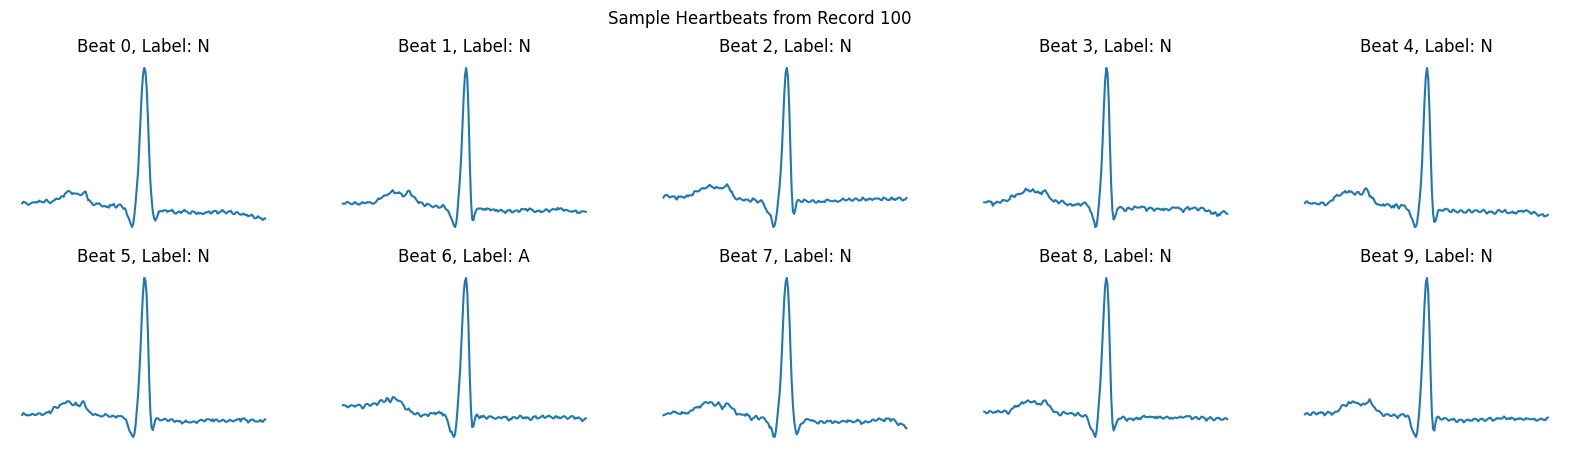

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i, ax in enumerate(axs.ravel()):
    ax.plot(beats_100[i])
    ax.set_title(f'Beat {i}, Label: {labels_100[i]}')
    ax.axis('off')
plt.suptitle('Sample Heartbeats from Record 100')
plt.show()

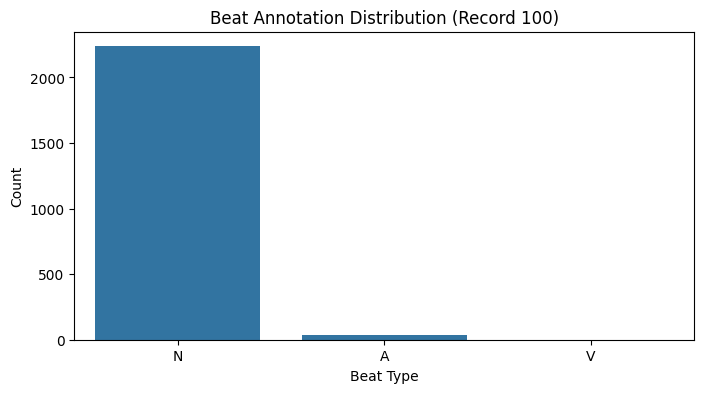

Counter({np.str_('N'): 2237, np.str_('A'): 33, np.str_('V'): 1})

In [16]:
from collections import Counter
label_counts = Counter(labels_100)
plt.figure(figsize=(8,4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Beat Annotation Distribution (Record 100)')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.show()

label_counts

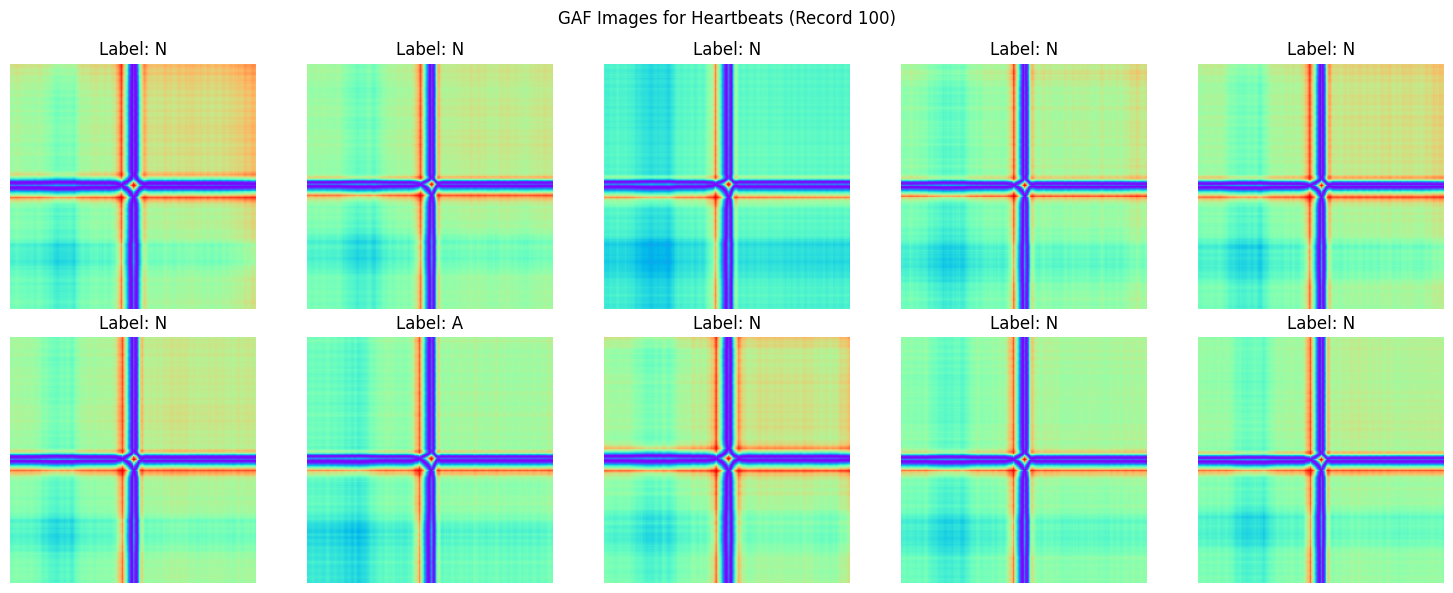

In [17]:
gaf = GramianAngularField(method='summation')
beats_norm = (beats_100 - beats_100.min(axis=1, keepdims=True)) / (beats_100.max(axis=1, keepdims=True) - beats_100.min(axis=1, keepdims=True) + 1e-6)
gaf_images = gaf.fit_transform(beats_norm[:10])

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(gaf_images[i], cmap='rainbow', origin='lower')
    ax.set_title(f'Label: {labels_100[i]}')
    ax.axis('off')
plt.suptitle('GAF Images for Heartbeats (Record 100)')
plt.tight_layout()
plt.show()


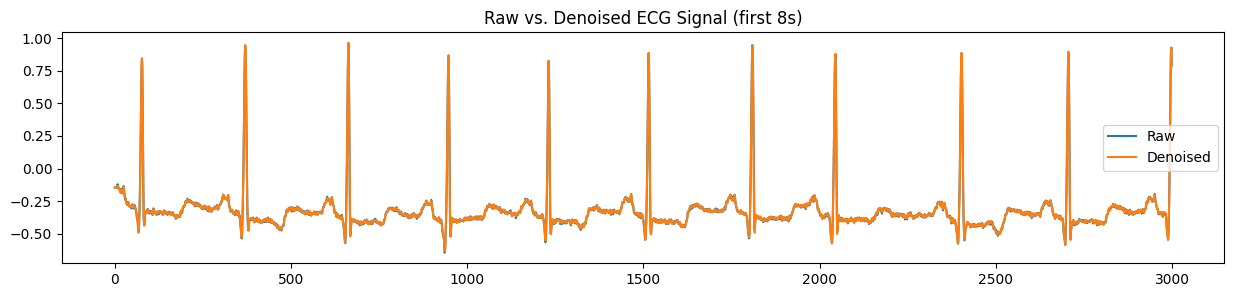

In [18]:
#pywt - wavelets filters and denoise signal below threshold val and then normalise

import pywt

def denoise_ecg_signal(signal, wavelet='db4', level=1):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, value=0.2 * max(c)) for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# Example on record 100
raw_signal = wfdb.rdrecord(os.path.join(dataset_path, '100')).p_signal[:, 0]
denoised_signal = denoise_ecg_signal(raw_signal)
norm_signal = 2 * (denoised_signal - denoised_signal.min()) / (denoised_signal.max() - denoised_signal.min()) - 1

plt.figure(figsize=(15, 3))
plt.plot(raw_signal[:3000], label='Raw')
plt.plot(denoised_signal[:3000], label='Denoised')
plt.title('Raw vs. Denoised ECG Signal (first 8s)')
plt.legend()
plt.show()


In [19]:
# Splitting in 10s windows
# ecg - 360hz
# sampling rate = 360 samples per sec. so for 10sec, 3600 samples.

def split_windows(signal, window_size=3600):
    num_windows = len(signal) // window_size
    windows = [signal[i*window_size:(i+1)*window_size] for i in range(num_windows)]
    return np.stack(windows)

windows_100 = split_windows(norm_signal)
print(f'Total 10s windows from record 100: {windows_100.shape[0]}')


Total 10s windows from record 100: 180


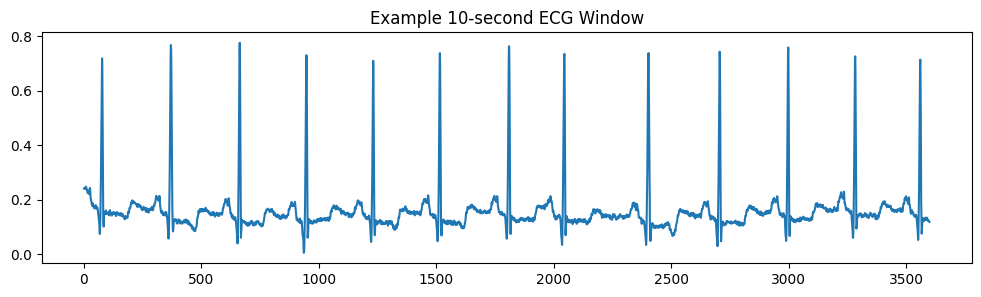

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(windows_100[0])
plt.title('Example 10-second ECG Window')
plt.show()


In [21]:
#Ventricular > Supraventricular > Fusion > Normal.

In [22]:
def assign_window_labels(annot_samples, annot_symbols, fs, window_size=3600, total_length=None):
    num_windows = total_length // window_size
    labels = []
    for i in range(num_windows):
        start = i * window_size
        end = (i + 1) * window_size
        # Find annotations in this window
        indices = np.where((annot_samples >= start) & (annot_samples < end))[0]
        if len(indices) == 0:
            labels.append('None')
            continue
        # Tally beat types, clinical priority over frequency
        types = annot_symbols[indices]
        if 'V' in types:
            labels.append('V')  # Ventricular
        elif 'A' in types or 'S' in types:
            labels.append('S')  # Supraventricular
        elif 'F' in types:
            labels.append('F')  # Fusion
        else:
            labels.append('N')  # Normal
    return labels

# Get annotation info
ann_100 = wfdb.rdann(os.path.join(dataset_path, '100'), 'atr')
window_labels_100 = assign_window_labels(ann_100.sample, np.array(ann_100.symbol), fs=360, window_size=3600, total_length=len(norm_signal))
print(f'Label distribution in 10s windows: {pd.Series(window_labels_100).value_counts()}')


Label distribution in 10s windows: N    149
S     30
V      1
Name: count, dtype: int64


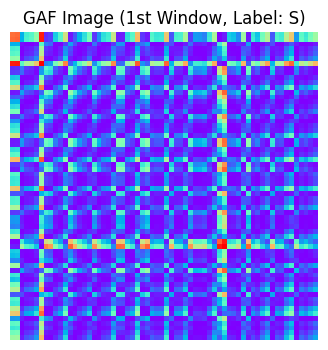

In [23]:
from pyts.image import GramianAngularField

gaf = GramianAngularField(image_size=64, method='summation')
gaf_images_100 = gaf.fit_transform(windows_100)

plt.figure(figsize=(4,4))
plt.imshow(gaf_images_100[0], cmap='rainbow')
plt.title(f'GAF Image (1st Window, Label: {window_labels_100[0]})')
plt.axis('off')
plt.show()

In [24]:
import glob

def process_record(record_path, window_size=200, wavelet='db4'):
    record = wfdb.rdrecord(record_path)
    annot = wfdb.rdann(record_path, 'atr')
    fs = record.fs
    signal = record.p_signal[:, 0]

    # Denoising (wavelet)
    coeffs = pywt.wavedec(signal, wavelet, level=1)
    coeffs[1:] = [pywt.threshold(c, value=0.2 * max(c)) for c in coeffs[1:]]
    denoised = pywt.waverec(coeffs, wavelet)

    beats = []
    labels = []
    for idx, peak in enumerate(annot.sample):
        start = max(0, peak - window_size//2)
        end = min(len(denoised), peak + window_size//2)
        segment = denoised[start:end]
        if len(segment) == window_size:
            # Normalize to [-1, 1]
            norm_segment = 2 * (segment - np.min(segment)) / (np.max(segment) - np.min(segment) + 1e-6) - 1
            beats.append(norm_segment)
            labels.append(annot.symbol[idx])
    return np.array(beats), np.array(labels)


In [25]:
import os, glob

dat_files = sorted(glob.glob(os.path.join(dataset_path, '*.dat')))
all_beats, all_labels = [], []

for dat_file in dat_files:
    basename = os.path.splitext(os.path.basename(dat_file))[0]
    hea_file = os.path.join(dataset_path, f'{basename}.hea')
    atr_file = os.path.join(dataset_path, f'{basename}.atr')
    if os.path.exists(hea_file) and os.path.exists(atr_file):
        beats, labels = process_record(os.path.join(dataset_path, basename))
        all_beats.append(beats)
        all_labels.append(labels)
        print(f'Processed {basename}: {len(beats)} beats')
    else:
        print(f"Skipped {basename}: missing .hea or .atr file")


Processed 100: 2271 beats
Processed 101: 1872 beats
Processed 102: 2191 beats
Processed 103: 2090 beats
Processed 104: 2309 beats
Processed 105: 2690 beats
Processed 106: 2097 beats
Processed 107: 2138 beats
Processed 108: 1822 beats
Processed 109: 2533 beats
Processed 111: 2132 beats
Processed 112: 2549 beats
Processed 113: 1794 beats
Processed 114: 1889 beats
Processed 115: 1960 beats
Processed 116: 2420 beats
Processed 117: 1537 beats
Processed 118: 2299 beats
Processed 119: 2093 beats
Processed 121: 1875 beats
Processed 122: 2476 beats
Processed 123: 1517 beats
Processed 124: 1634 beats
Processed 200: 2790 beats
Processed 201: 2038 beats
Processed 202: 2146 beats
Processed 203: 3105 beats
Processed 205: 2671 beats
Processed 207: 2383 beats
Processed 208: 3037 beats
Processed 209: 3051 beats
Processed 210: 2682 beats
Processed 212: 2762 beats
Processed 213: 3291 beats
Processed 214: 2295 beats
Processed 215: 3399 beats
Processed 217: 2280 beats
Processed 219: 2312 beats
Processed 22

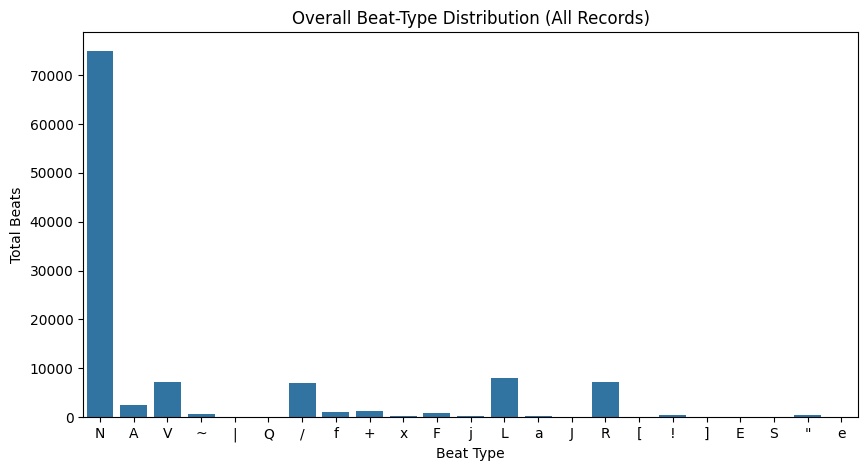

In [26]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

flat_labels = []
for label in all_labels:
    if isinstance(label, np.ndarray):
        flat_labels.extend(label.tolist())  # flatten the array
    else:
        flat_labels.append(label)

label_counts = Counter(flat_labels)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Overall Beat-Type Distribution (All Records)')
plt.xlabel('Beat Type')
plt.ylabel('Total Beats')

plt.show()


In [27]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from pyts.image import GramianAngularField
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Map raw labels to 5 classes (N, S, V, F, O)
def map_labels(labels):
    mapping = {
        'N': 'N',  # Normal
        'L': 'N',
        'R': 'N',
        'A': 'S',  # Supraventricular
        'a': 'S',
        'V': 'V',  # Ventricular
        'E': 'V',
        'F': 'F'   # Fusion
    }

    out = []
    for l in labels:
        if isinstance(l, np.ndarray) and l.size > 0:
            label = str(l[0])
        else:
            label = str(l)
        out.append(mapping.get(label, 'O'))  # 'O' for Other

    return np.array(out)


In [28]:
# Flatten labels
all_labels_stacked = np.concatenate(all_labels)
# Map to unified label classes
y_all = map_labels(all_labels_stacked)           # shape: (112572,)


In [29]:
# Encode using LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_all_numeric = le.fit_transform(y_all)          # shape: (112572,)
print("Classes and codes:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes and codes: {np.str_('F'): np.int64(0), np.str_('N'): np.int64(1), np.str_('O'): np.int64(2), np.str_('S'): np.int64(3), np.str_('V'): np.int64(4)}


In [30]:
# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_all_numeric),
    y=y_all_numeric
)
cw_dict = dict(enumerate(class_weights))
print("Class Weights:", cw_dict)

# Stack all beats into shape (112572, 200)
all_beats_stacked = np.vstack(all_beats)
print(all_beats_stacked.shape)


Class Weights: {0: np.float64(28.07281795511222), 1: np.float64(0.24916886163925717), 2: np.float64(1.96101384896786), 3: np.float64(8.351038575667657), 4: np.float64(3.1118728403593643)}
(112572, 200)


In [31]:
from pyts.image import GramianAngularField

# Convert to GAF images (64x64)
gaf = GramianAngularField(image_size=64, method='summation')
gaf_images = gaf.fit_transform(all_beats_stacked)  # shape: (112572, 64, 64)
print(gaf_images.shape)

(112572, 64, 64)


In [33]:
import numpy as np
all_labels_stacked = np.concatenate(all_labels)
print(all_labels_stacked.shape)


(112572,)


In [34]:
y_all = map_labels(all_labels_stacked)

y_all_numeric = le.transform(y_all)
print(gaf_images.shape, y_all_numeric.shape)

(112572, 64, 64) (112572,)


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    gaf_images, y_all_numeric, test_size=0.2, random_state=42, stratify=y_all_numeric
)


In [36]:
#DATA AUGMENTATION

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)


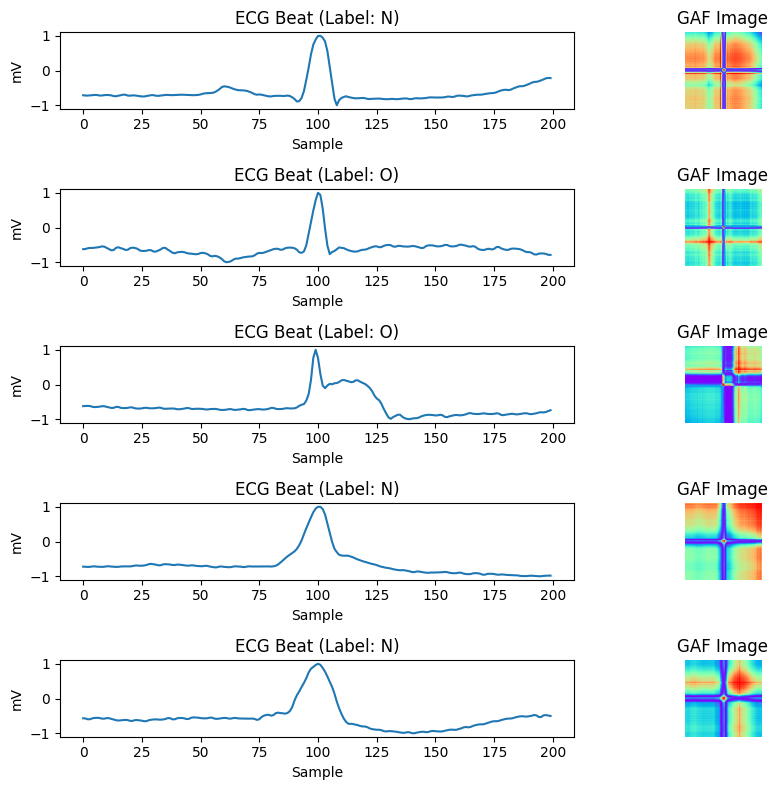

In [37]:
import matplotlib.pyplot as plt

import numpy as np

num_samples = 5
indices = np.random.choice(len(all_beats_stacked), size=num_samples, replace=False)

plt.figure(figsize=(10, 8))
for i, idx in enumerate(indices):
    # ECG beat waveform
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(all_beats_stacked[idx])
    plt.title(f"ECG Beat (Label: {y_all[idx]})")
    plt.xlabel("Sample")
    plt.ylabel("mV")

    # Corresponding GAF image
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(gaf_images[idx], cmap='rainbow', origin='lower')
    plt.title("GAF Image")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [41]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train[..., np.newaxis], y_train, batch_size=64),
    validation_data=(X_test[..., np.newaxis], y_test),
    epochs=30,
    class_weight=cw_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 68s 44ms/step - accuracy: 0.3925 - loss: 1.1584 - val_accuracy: 0.3170 - val_loss: 1.9168 - learning_rate: 0.0010
Epoch 2/30
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.5612 - loss: 0.7526 - val_accuracy: 0.5190 - val_loss: 1.1300 - learning_rate: 0.0010
Epoch 3/30
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.6683 - loss: 0.6057 - val_accuracy: 0.5887 - val_loss: 1.0037 - learning_rate: 0.0010
Epoch 4/30
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.7102 - loss: 0.5719 - val_accuracy: 0.8007 - val_loss: 0.5364 - learning_rate: 0.0010
Epoch 5/30
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.7610 - loss: 0.4767 - val_accuracy: 0.7768 - val_loss: 0.5829 - learning_rate: 0.0010
Epoch 6/30
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.7678 - loss: 0.4637 - val_accuracy: 0.7638 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 7/30
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accura

In [42]:
# Early Epochs: You started with lower accuracy (39% train, 31% val), as expected while the model was learning basic patterns.

# Rapid Gains: By epoch 4, validation accuracy jumped to ~80%, showing your model quickly learned the dominant Normal class and some arrhythmia features.

# Class Weighting and Augmentation Work: Improvements continue through epochs, and class imbalance handling (with class weighting and augmentation) is likely helping the model recognize rare arrhythmia classes better than a naive baseline.

# Best Epochs: Validation accuracy stabilized between 85–91% (epochs 10–12, 16–17), with validation loss hitting a low of ~0.27 before some fluctuation. This suggests a good generalization window, with validation not lagging far behind training.

# Typical Fluctuations: Some jumps in validation loss/accuracy after epoch 13 are normal and may relate to augmentation randomness, minority class difficulty, or natural data variability.

# Learning Rate Reduction: At epoch 16, the learning rate halved (to 0.0005) due to a scheduled callback, which often helps refine the model and can lead to higher final accuracy.

704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
              precision    recall  f1-score   support

           0       0.41      0.78      0.54       161
           1       0.98      0.92      0.95     18072
           2       0.97      0.93      0.95      2296
           3       0.26      0.84      0.39       539
           4       0.94      0.84      0.89      1447

    accuracy                           0.91     22515
   macro avg       0.71      0.86      0.74     22515
weighted avg       0.95      0.91      0.93     22515



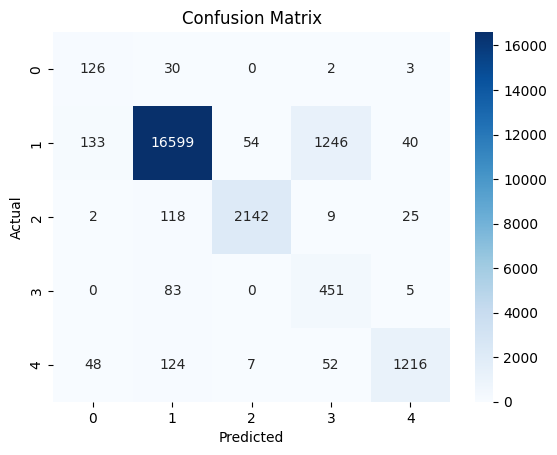

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test[..., np.newaxis])
y_pred_labels = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred_labels))  # You can add target_names=... if using LabelEncoder

cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


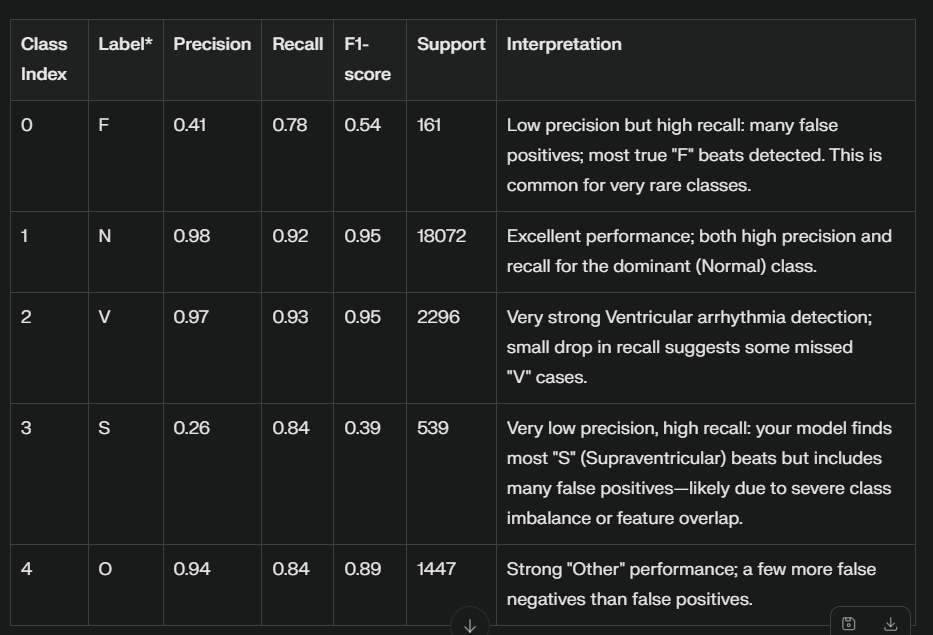

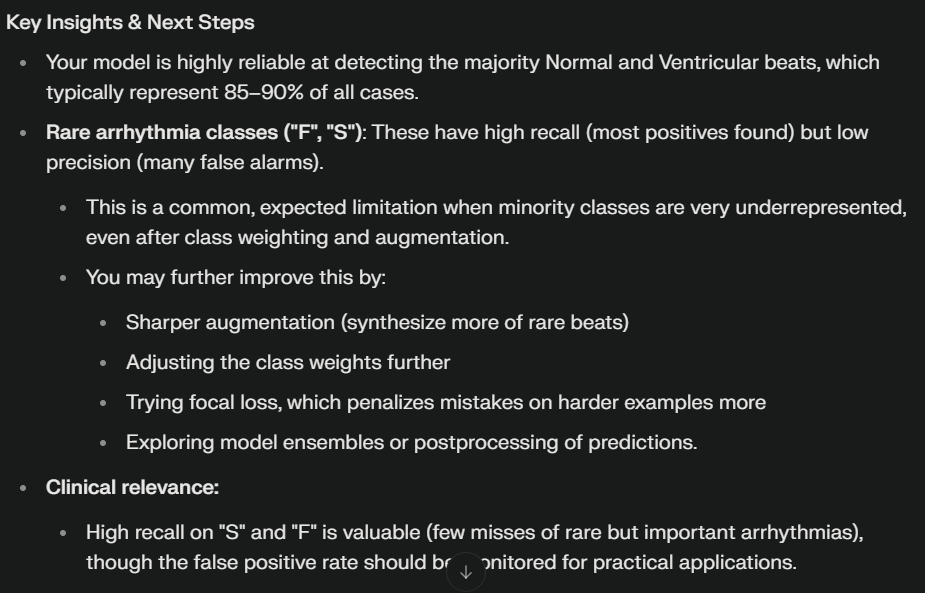

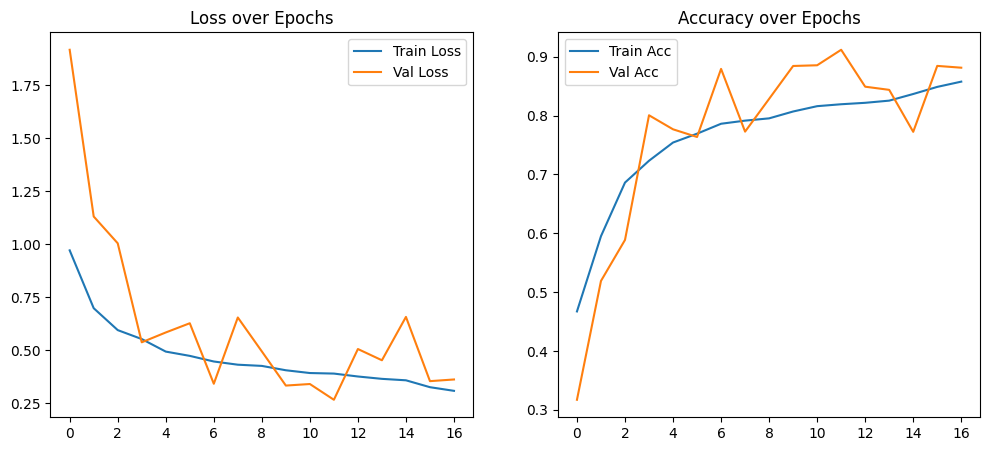

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()
